# Grims2.0-12

Collect raw data and organize it into a suitable ASDF structure where it makes sense.

**ATTENTION**  
*This will create new asdf files from scratch and potentially delete existing additions that were
already made.*

Experiment date: 2012-07-03

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import asdf
import pandas as pd
from pathlib import Path

from bismarckload import load_meta

## Load Raw Data

### Metadata

In [2]:
md = load_meta('../../data/2.0/2012-07-03_Grims2.0-12.log')
md

{'device': '6124-2',
 'channels': ['Dev3/ai0', 'Dev3/ai1', 'Dev3/ai2', 'Dev3/ai3'],
 'sampling rate': 4000000.0,
 'name': 'Grims2.0-12',
 'date': datetime.datetime(2012, 7, 3, 0, 0),
 'trigger': False,
 'slope': 'rising',
 'trigger_level': 0.5,
 'trigger_source': 'PFI0',
 'pretrigger': 0.0,
 'samples': 24000000,
 'names': ['KISTLERold', 'KISTLER09', 'KISTLER10', 'KISTLER11'],
 'scales': ['1bar', '1bar', '1bar', '1bar']}

In [3]:
SRATE = md['sampling rate']
SRATE

4000000.0

### Main Data

In [4]:
data = pd.read_csv(
    '../../data/2.0/2012-07-03_Grims2.0-12.txt',
    sep='\t', names=['pold', 'p09', 'p10', 'p11'], index_col=0, skiprows=2
)
data.index.name = 't'
# Re-generate time line, to fix the 1e5 sample bug
data.index = pd.Index(data=np.arange(0.0, len(data) / SRATE, 1 / SRATE), name='t')
# data.loc[:, :] *= 1e5

data.head()

pold       p09       p10       p11
t                                                   
0.000000e+00 -0.006841  0.002519  0.009034  0.010335
2.500000e-07 -0.006216  0.002831  0.008097  0.007208
5.000000e-07 -0.006529  0.005019  0.008409  0.004394
7.500000e-07 -0.005903  0.006581  0.009346  0.002206
1.000000e-06 -0.005903  0.008455  0.009034 -0.000608

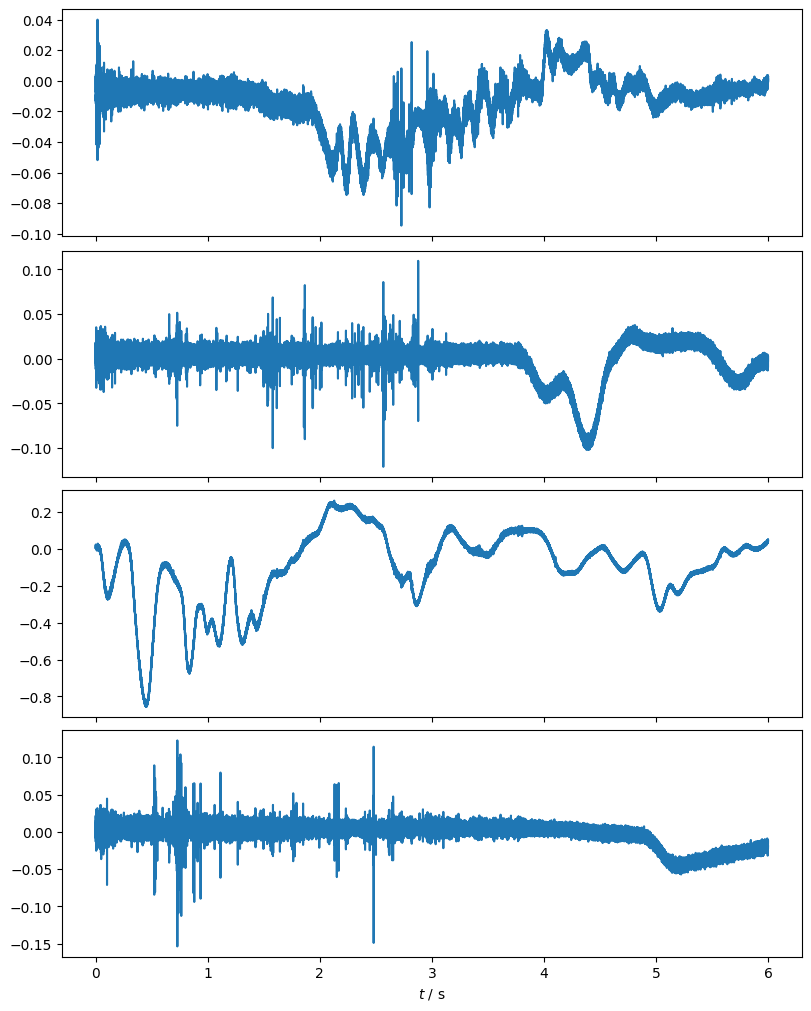

In [5]:
fig, axs = plt.subplots(nrows=4, sharex=True, constrained_layout=True)

for ax, col in zip(axs, data.columns):
    ax.plot(data.loc[:, col], label=col)
axs[-1].set(
    xlabel=r'$t\ /\ \mathrm{s}$'
)
fig.set_size_inches(8, 10)

## Save to `asdf`

### Create a "Toplevel" File

In [6]:
md['name']

'Grims2.0-12'

In [7]:
afname = f'../../data/2.0/asdf/{md["name"]}.asdf'
afname

'../../data/2.0/asdf/Grims2.0-12.asdf'

In [8]:
af = asdf.AsdfFile(uri=afname)

In [9]:
af['raw'] = {}
raw = af['raw']
raw['metadata'] = md

### Separate File for Each Sensor

Save each sensor log into a separate file and create a reference entry in the toplevel thing

In [10]:
auri = Path(af.uri)
# time column
afr = asdf.AsdfFile(uri=auri.parent / f"{auri.stem}_raw-time{auri.suffix}")
afr.tree = {'experiment': md['name'], 'date': md['date'],
            'srate': SRATE, 'unit': 's', 'time': data.index.values}
afr.write_to(afr.uri, all_array_storage='internal', all_array_compression='zlib')
raw['time'] = {'$ref': f"{afr.uri.name}#time"}

# pressure
for col, name in zip(data.columns, md['names']):
    afr = asdf.AsdfFile(uri=auri.parent / f"{auri.stem}_raw-{name}{auri.suffix}")
    afr.tree = {
        'experiment': md['name'], 'date': md['date'], 'srate': SRATE,
        'unit': 'bar', name: data.loc[:, col].values
    }
    afr.write_to(afr.uri, all_array_compression='zlib')
    raw[name] = {'$ref': f"{afr.uri.name}#{name}"}

### Add a History Entry

In [11]:
af.add_history_entry(
    description="Add raw data and raw metadata.\n"
    "- Elements written:\n"
    "  - 'raw/metadata'\n"
    "  - 'raw/data'\n"
    "- Program source: 'anl/prep_grims2.0-12.ipynb'",
    software={
        "name": "Bismarck Analysis Stack.",
        "author": "The PVL Team",
        "homepage": "https://to.do",
        "version": "0.1"
    }
)

### Write Out and Close

In [12]:
af.find_references()

In [13]:
af.info(max_rows=50)

root (AsdfObject)
├─raw (dict)
│ ├─metadata (dict)
│ │ ├─device (str): 6124-2
│ │ ├─channels (list)
│ │ │ ├─[0] (str): Dev3/ai0
│ │ │ ├─[1] (str): Dev3/ai1
│ │ │ ├─[2] (str): Dev3/ai2
│ │ │ └─[3] (str): Dev3/ai3
│ │ ├─sampling rate (float): 4000000.0
│ │ ├─name (str): Grims2.0-12
│ │ ├─date (datetime): 2012-07-03 00:00:00
│ │ ├─trigger (bool): False
│ │ ├─slope (str): rising
│ │ ├─trigger_level (float): 0.5
│ │ ├─trigger_source (str): PFI0
│ │ ├─pretrigger (float): 0.0
│ │ ├─samples (int): 24000000
│ │ ├─names (list)
│ │ │ ├─[0] (str): KISTLERold
│ │ │ ├─[1] (str): KISTLER09
│ │ │ ├─[2] (str): KISTLER10
│ │ │ └─[3] (str): KISTLER11
│ │ └─scales (list)
│ │   ├─[0] (str): 1bar
│ │   ├─[1] (str): 1bar
│ │   ├─[2] (str): 1bar
│ │   └─[3] (str): 1bar
│ ├─time (Reference): <Reference (unloaded) to 'Grims2.0-12_raw-time.asdf#time'>
│ ├─KISTLERold (Reference): <Reference (unloaded) to 'Grims2.0-12_raw-KISTLERold.asdf#KISTLERold'>
│ ├─KISTLER09 (Reference): <Reference (unloaded) to 'Grims2.0-12

In [14]:
af.write_to(af.uri)

In [15]:
af.close()

In [16]:
del data

### Re-Open and Check Data

In [17]:
af = asdf.open('../../data/2.0/asdf/Grims2.0-12.asdf', mode='r')

In [18]:
af.find_references()

In [19]:
af['raw']['time'][:10]

array([0.00e+00, 2.50e-07, 5.00e-07, 7.50e-07, 1.00e-06, 1.25e-06,
       1.50e-06, 1.75e-06, 2.00e-06, 2.25e-06])

In [20]:
af['raw']['KISTLERold'][:10]

array([-0.0068414 , -0.00621592, -0.00652866, -0.00590317, -0.00590317,
       -0.00559043, -0.00621592, -0.00621592, -0.00590317, -0.00559043])

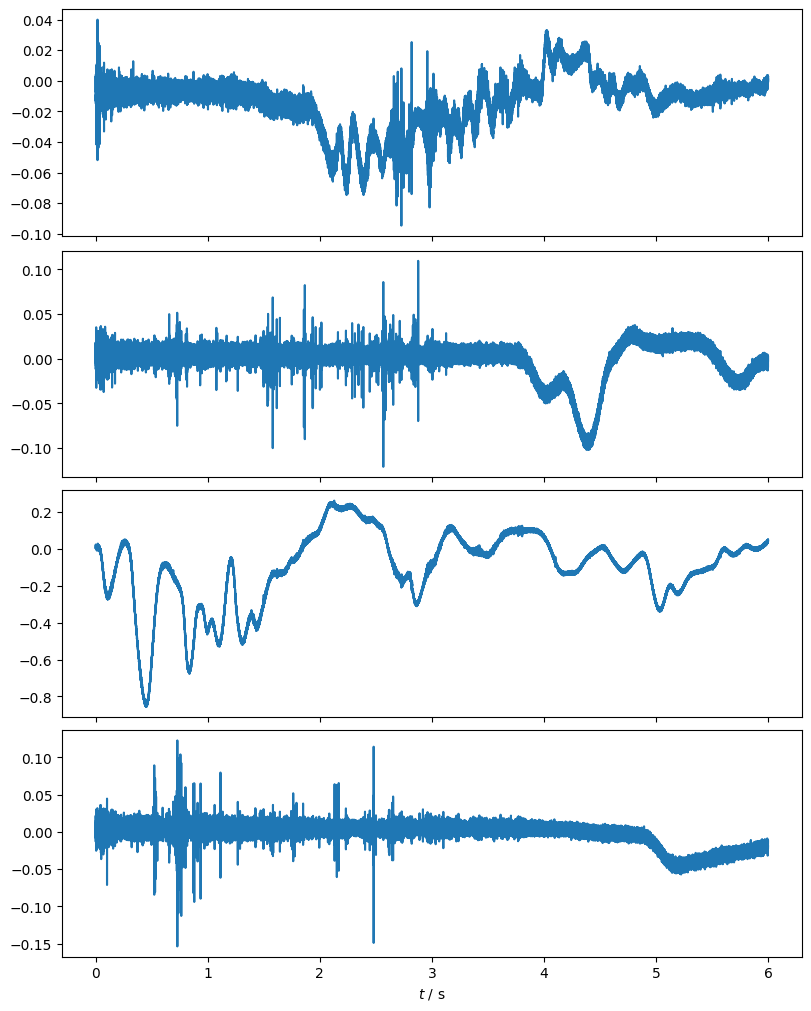

In [21]:
fig, axs = plt.subplots(nrows=4, sharex=True, constrained_layout=True)

for ax, col in zip(axs, ["KISTLERold", "KISTLER09", "KISTLER10", "KISTLER11"]):
    ax.plot(af['raw']['time'][:], af['raw'][col][:], label=col)
axs[-1].set(
    xlabel=r'$t\ /\ \mathrm{s}$'
)
fig.set_size_inches(8, 10)